## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Используем один из датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [7]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [54]:
# Число деревьев в ансамбле
n_trees = [10, 15, 20, 25, 30]

# Максимальная глубина деревьев
max_depth = [3, 5 , 7]

# Шаг
eta = 0.1

forests = []

for num in n_trees:
    for depth in max_depth:
    
        coefs = [1] * num
    
        trees, train_errors, test_errors = gb_fit(num, depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        train_err = round(mean_squared_error(y_train, train_prediction))
        test_err = round(mean_squared_error(y_test, test_prediction))
        
                
        forests.append([num, depth, train_err, test_err])

In [55]:
forests

[[10, 3, 2519, 3256],
 [10, 5, 1320, 3748],
 [10, 7, 743, 4033],
 [15, 3, 1813, 3094],
 [15, 5, 591, 3724],
 [15, 7, 189, 3772],
 [20, 3, 1512, 3100],
 [20, 5, 398, 3757],
 [20, 7, 65, 3739],
 [25, 3, 1356, 3210],
 [25, 5, 273, 3866],
 [25, 7, 29, 3815],
 [30, 3, 1222, 3271],
 [30, 5, 210, 3890],
 [30, 7, 14, 3814]]

Построим график зависимости

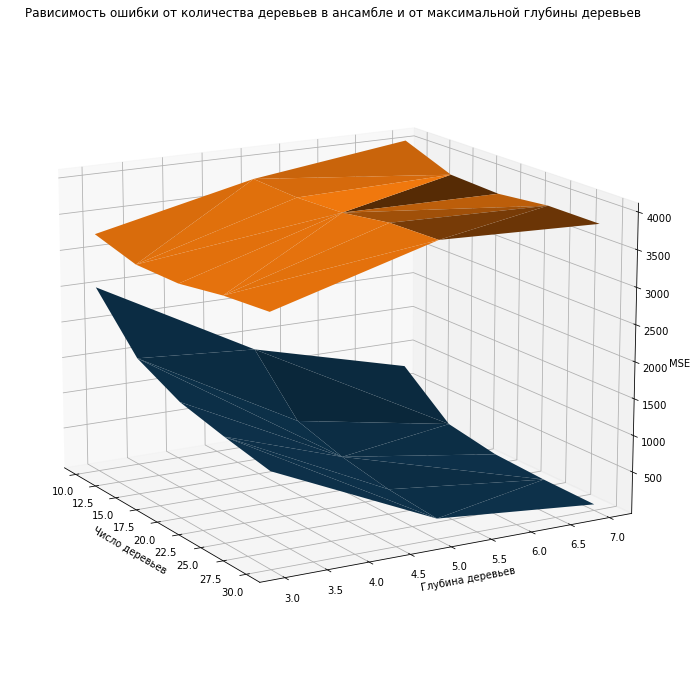

In [60]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
x = [f[0] for f in forests]
y = [f[1] for f in forests]
z = [f[2] for f in forests]    
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

x = [f[0] for f in forests]
y = [f[1] for f in forests]
z = [f[3] for f in forests]
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

ax.view_init(15, -30)
ax.set_xlabel('Число деревьев')
ax.set_ylabel('Глубина деревьев')
ax.set_zlabel('MSE')
ax.set_title('Pависимость ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев')

plt.show()

На графике отражена зависимость ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.Как видно по графику ошибка на обучающей выборке падает при увеличении обоих параметров, однако на тестовой выборке картина выглядит немного иначе, при увеличении параметров ошибка возрастает, это связано с переобучением модели. В нашем случае я бы оставил 10 деревьев при глубине 3.
